### Imports

In [0]:
import keras # Importing Keras
import tensorflow as tf #Importing TensorFlow
from keras import backend as K # plaidml alias
from keras.datasets import fashion_mnist # Import the mnist dataset
from keras.layers import Input, Dense # Layers to be used for building our model
from keras.models import Model # The class used to create a model
from keras.optimizers import SGD, RMSprop, Adam, Adadelta
from keras.utils import np_utils # Utilities to manipulate numpy arrays
from tensorflow import set_random_seed # Used for reproducible experiments

import gc
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

Using TensorFlow backend.


### Data manipulation

**Task**: Given an image of handwritten digit find the digit

**Data**:
- The data are grayscale 28*28 images of fashion clothing elements
- We will use an MLP to classify them so we first need to flatten them
- The values of the inputs are in [0, 255] so we normalize them to [0, 1]

In [0]:
batch_size = 80
classes = 10
epochs = 10

(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()
X_train = X_train.reshape(60000, 784)
X_test = X_test.reshape(10000, 784)
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255
Y_train = np_utils.to_categorical(y_train, classes)
Y_test = np_utils.to_categorical(y_test, classes)

### Plotting results

In [0]:
def plot_history(hs, epochs, metric):
    plt.clf()
    plt.rcParams['figure.figsize'] = [10, 5]
    plt.rcParams['font.size'] = 16
    for label in hs:
        plt.plot(hs[label].history[metric], label='{0:s} train {1:s}'.format(label, metric))
        plt.plot(hs[label].history['val_{0:s}'.format(metric)], label='{0:s} validation {1:s}'.format(label, metric))
    x_ticks = np.arange(0, epochs + 1, epochs / 10)
    x_ticks [0] += 1
    plt.xticks(x_ticks)
    plt.ylim((0, 1))
    plt.xlabel('Epochs')
    plt.ylabel('Loss' if metric=='loss' else 'Accuracy')
    plt.legend()
    plt.show()


### Cleaning up

In [0]:
def clean_up(model):
    K.clear_session()
    del model
    gc.collect()


### Model creation

- We will use a Functional Model.
    - It is more flexible than the `Sequential` model but ...
    - We need to be careful with the sizes of the layers.
- The first layer should always be an `Input` layer where we specify the input of the model, e.g., the training data
- The other layers can be whatever we want and for each layer we must:
    - Define the input to the layer, i.e., another layer.
    - Define the number of units which also defines the output size.
        - The output size must be always equal to the number of units of the next layer.


In [0]:
def train_model(
        optimizer,
        epochs,
        batch_size,
        hidden_layers,
        hidden_activation='relu',
        output_activation='softmax'):
    
    np.random.seed(1402) # Define the seed for numpy to have reproducible experiments.
    set_random_seed(1402) # Define the seed for Tensorflow to have reproducible experiments.
    
    # Define the input layer.
    input = Input(
        shape=(784,),
        name='Input'
    )

    x = input
    # Define the remaining hidden layers.
    for i in range(hidden_layers):
  
        x = Dense(
            units=120,
            kernel_initializer='glorot_uniform',
            activation=hidden_activation,
            name='Hidden-{0:d}2'.format(i)
        )(x)
     
        
    # Define the output layer.
    output = Dense(
        units=classes,
        kernel_initializer='uniform',
        activation=output_activation,
        name='Output'
    )(x)

    # Define the model and train it.
    model = Model(inputs=input, outputs=output)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    hs = model.fit(
        x=X_train,
        y=Y_train,
        validation_split=0.1, # use 10% of the training data as validation data
        epochs=epochs,
        verbose=1,
        shuffle=True,
        batch_size=batch_size
    )
    print('Finished training.')
    print('------------------')
    model.summary() # Print a description of the model.
    return model, hs


### Using SGD

In [0]:
# Using SGD
optimizer = SGD(lr=0.06, decay=0.0)

# Logistic Regression
lr_model_sgd, lr_hs_sgd = train_model(
    optimizer=optimizer,
    epochs=epochs,
    batch_size=batch_size,
    hidden_layers=0,
    hidden_activation='relu',
    output_activation='softmax'
)

# Evaluate on test data and show all the results.
lr_eval_sgd = lr_model_sgd.evaluate(X_test, Y_test, verbose=1) #If I comment out this line "nothing" happens due to validation_split argument *jasKIP*
clean_up(model=lr_model_sgd)

Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 [==============================] - 2s 41us/step - loss: 0.7064 - acc: 0.7689 - val_loss: 0.5480 - val_acc: 0.8198
Epoch 2/10
54000/54000 [==============================] - 2s 41us/step - loss: 0.5280 - acc: 0.8239 - val_loss: 0.5067 - val_acc: 0.8263
Epoch 3/10
54000/54000 [==============================] - 2s 41us/step - loss: 0.4928 - acc: 0.8341 - val_loss: 0.4900 - val_acc: 0.8297
Epoch 4/10
54000/54000 [==============================] - 2s 41us/step - loss: 0.4725 - acc: 0.8403 - val_loss: 0.4609 - val_acc: 0.8412
Epoch 5/10
54000/54000 [==============================] - 2s 41us/step - loss: 0.4604 - acc: 0.8451 - val_loss: 0.4522 - val_acc: 0.8430
Epoch 6/10
54000/54000 [==============================] - 2s 41us/step - loss: 0.4510 - acc: 0.8459 - val_loss: 0.4419 - val_acc: 0.8460
Epoch 7/10
54000/54000 [==============================] - 2s 41us/step - loss: 0.4437 - acc: 0.8490 - val_loss: 0.4402 - val_acc:

### Logistic Regression results

In [0]:
print("Train Loss     : {0:.5f}".format(lr_hs_sgd.history['loss'][-1]))
print("Validation Loss: {0:.5f}".format(lr_hs_sgd.history['val_loss'][-1]))
print("Test Loss      : {0:.5f}".format(lr_eval_sgd[0]))
print("---")
print("Train Accuracy     : {0:.5f}".format(lr_hs_sgd.history['acc'][-1]))
print("Validation Accuracy: {0:.5f}".format(lr_hs_sgd.history['val_acc'][-1]))
print("Test Accuracy      : {0:.5f}".format(lr_eval_sgd[1]))


# Plot train and validation error per epoch.
plot_history(hs={'LR': lr_hs_sgd}, epochs=epochs, metric='loss')
plot_history(hs={'LR': lr_hs_sgd}, epochs=epochs, metric='acc')

Train Loss     : 0.42887
Validation Loss: 0.42503


NameError: ignored

In [0]:
# Using SGD
optimizer = SGD(lr=0.01)

# MLP
mlp_model_sgd, mlp_hs_sgd = train_model(
    optimizer=optimizer,
    epochs=epochs,
    batch_size=batch_size,
    hidden_layers=1,
    hidden_activation='relu',
    output_activation='softmax'
)

# Evaluate on test data and show all the results.
mlp_eval_sgd = mlp_model_sgd.evaluate(X_test, Y_test, verbose=1)
clean_up(model=mlp_model_sgd)

Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 [==============================] - 2s 46us/step - loss: 1.2917 - acc: 0.6166 - val_loss: 0.8346 - val_acc: 0.7093
Epoch 2/10
54000/54000 [==============================] - 2s 45us/step - loss: 0.7545 - acc: 0.7398 - val_loss: 0.6713 - val_acc: 0.7723
Epoch 3/10
54000/54000 [==============================] - 2s 45us/step - loss: 0.6436 - acc: 0.7822 - val_loss: 0.5959 - val_acc: 0.7968
Epoch 4/10
54000/54000 [==============================] - 2s 45us/step - loss: 0.5842 - acc: 0.8042 - val_loss: 0.5531 - val_acc: 0.8137
Epoch 5/10
54000/54000 [==============================] - 2s 45us/step - loss: 0.5471 - acc: 0.8137 - val_loss: 0.5288 - val_acc: 0.8147
Epoch 6/10
54000/54000 [==============================] - 2s 45us/step - loss: 0.5224 - acc: 0.8226 - val_loss: 0.5087 - val_acc: 0.8228
Epoch 7/10
54000/54000 [==============================] - 2s 45us/step - loss: 0.5033 - acc: 0.8285 - val_loss: 0.4900 - val_acc:

### Logistic Regression vs. MLP results

Train Loss     : 0.46612
Validation Loss: 0.45694
Test Loss      : 0.49017
---
Train Accuracy     : 0.84102
Validation Accuracy: 0.83767
Test Accuracy      : 0.82620


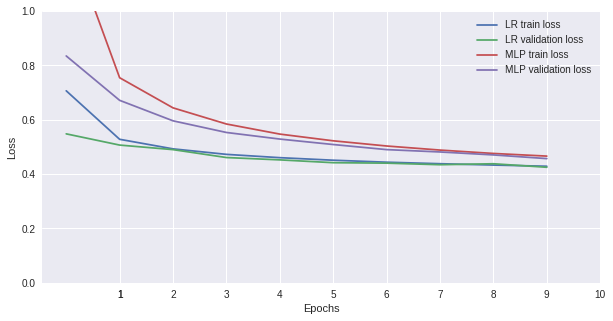

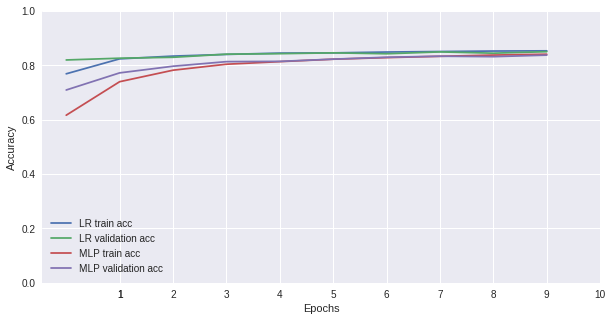

In [0]:
print("Train Loss     : {0:.5f}".format(mlp_hs_sgd.history['loss'][-1]))
print("Validation Loss: {0:.5f}".format(mlp_hs_sgd.history['val_loss'][-1]))
print("Test Loss      : {0:.5f}".format(mlp_eval_sgd[0]))
print("---")
print("Train Accuracy     : {0:.5f}".format(mlp_hs_sgd.history['acc'][-1]))
print("Validation Accuracy: {0:.5f}".format(mlp_hs_sgd.history['val_acc'][-1]))
print("Test Accuracy      : {0:.5f}".format(mlp_eval_sgd[1]))


# Plot train and validation error per epoch.
plot_history(hs={'LR': lr_hs_sgd, 'MLP': mlp_hs_sgd}, epochs=epochs, metric='loss')
plot_history(hs={'LR': lr_hs_sgd, 'MLP': mlp_hs_sgd}, epochs=epochs, metric='acc')

### Using Adam

In [0]:
# Using Adam
optimizer = Adam(lr=.001)

# Logistic Regression
lr_model_adam, lr_hs_adam = train_model(
    optimizer=optimizer,
    epochs=epochs,
    batch_size=batch_size,
    hidden_layers=0,
    hidden_activation='relu',
    output_activation='softmax'
)

# Evaluate on test data and show all the results.
lr_eval_adam = lr_model_adam.evaluate(X_test, Y_test, verbose=1)
clean_up(model=lr_model_adam)

Train on 54000 samples, validate on 6000 samples
Epoch 1/10
54000/54000 [==============================] - 3s 49us/step - loss: 0.6930 - acc: 0.7696 - val_loss: 0.5202 - val_acc: 0.8248
Epoch 2/10
54000/54000 [==============================] - 3s 47us/step - loss: 0.4981 - acc: 0.8323 - val_loss: 0.4830 - val_acc: 0.8345
Epoch 3/10
54000/54000 [==============================] - 3s 47us/step - loss: 0.4609 - acc: 0.8438 - val_loss: 0.4481 - val_acc: 0.8468
Epoch 4/10
54000/54000 [==============================] - 3s 47us/step - loss: 0.4420 - acc: 0.8499 - val_loss: 0.4392 - val_acc: 0.8492
Epoch 5/10
54000/54000 [==============================] - 3s 47us/step - loss: 0.4291 - acc: 0.8538 - val_loss: 0.4322 - val_acc: 0.8505
Epoch 6/10
54000/54000 [==============================] - 3s 47us/step - loss: 0.4214 - acc: 0.8557 - val_loss: 0.4340 - val_acc: 0.8473
Epoch 7/10
54000/54000 [==============================] - 3s 47us/step - loss: 0.4139 - acc: 0.8587 - val_loss: 0.4247 - val_acc:

### Logistic Regression results

Train Loss     : 0.39990
Validation Loss: 0.41223
Test Loss      : 0.44911
---
Train Accuracy     : 0.86302
Validation Accuracy: 0.85517
Test Accuracy      : 0.84390


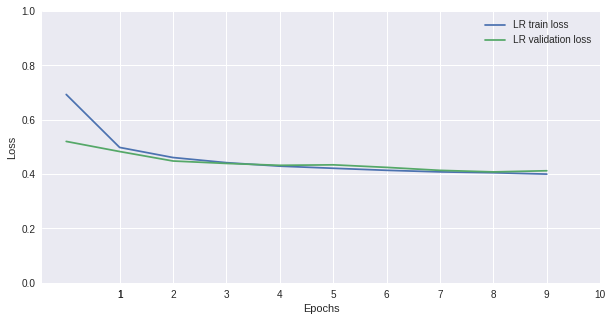

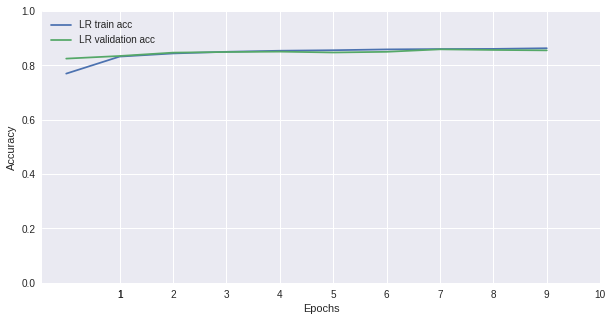

In [0]:
print("Train Loss     : {0:.5f}".format(lr_hs_adam.history['loss'][-1]))
print("Validation Loss: {0:.5f}".format(lr_hs_adam.history['val_loss'][-1]))
print("Test Loss      : {0:.5f}".format(lr_eval_adam[0]))
print("---")
print("Train Accuracy     : {0:.5f}".format(lr_hs_adam.history['acc'][-1]))
print("Validation Accuracy: {0:.5f}".format(lr_hs_adam.history['val_acc'][-1]))
print("Test Accuracy      : {0:.5f}".format(lr_eval_adam[1]))


# Plot train and validation error per epoch.
plot_history(hs={'LR': lr_hs_adam}, epochs=epochs, metric='loss')
plot_history(hs={'LR': lr_hs_adam}, epochs=epochs, metric='acc')

In [0]:
# Using Adam
optimizer = Adam(lr=.01)

# MLP
mlp_model_adam, mlp_hs_adam = train_model(
    optimizer=optimizer,
    epochs=epochs,
    batch_size=batch_size,
    hidden_layers=4,
    hidden_activation='relu',
    output_activation='softmax'
)

# Evaluate on test data and show all the results.
mlp_eval_adam = mlp_model_adam.evaluate(X_test, Y_test, verbose=1)
clean_up(model=mlp_model_adam)

Train on 54000 samples, validate on 6000 samples
Epoch 1/100
54000/54000 [==============================] - 1s 21us/step - loss: 0.7265 - acc: 0.7275 - val_loss: 0.4727 - val_acc: 0.8240
Epoch 2/100
54000/54000 [==============================] - 1s 15us/step - loss: 0.4140 - acc: 0.8470 - val_loss: 0.4319 - val_acc: 0.8460
Epoch 3/100
54000/54000 [==============================] - 1s 16us/step - loss: 0.3711 - acc: 0.8640 - val_loss: 0.3913 - val_acc: 0.8518
Epoch 4/100
54000/54000 [==============================] - 1s 16us/step - loss: 0.3386 - acc: 0.8751 - val_loss: 0.3681 - val_acc: 0.8660
Epoch 5/100
54000/54000 [==============================] - 1s 15us/step - loss: 0.3299 - acc: 0.8785 - val_loss: 0.3566 - val_acc: 0.8720
Epoch 6/100
54000/54000 [==============================] - 1s 16us/step - loss: 0.3131 - acc: 0.8847 - val_loss: 0.3519 - val_acc: 0.8742
Epoch 7/100
54000/54000 [==============================] - 1s 16us/step - loss: 0.3091 - acc: 0.8868 - val_loss: 0.3473 - v

### Logistic Regression vs. MLP results

Train Loss     : 0.16372
Validation Loss: 0.43672
Test Loss      : 0.46480
---
Train Accuracy     : 0.94156
Validation Accuracy: 0.88867
Test Accuracy      : 0.88200


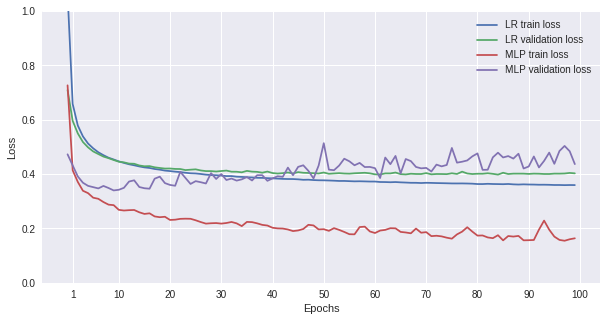

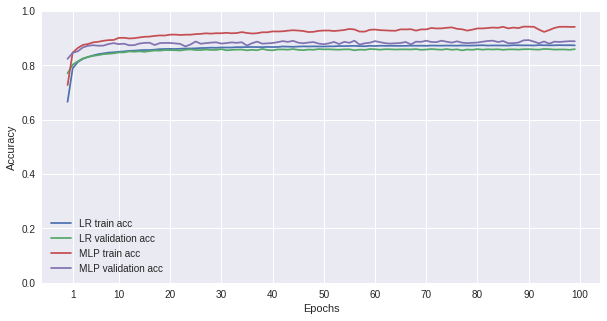

In [0]:
print("Train Loss     : {0:.5f}".format(mlp_hs_adam.history['loss'][-1]))
print("Validation Loss: {0:.5f}".format(mlp_hs_adam.history['val_loss'][-1]))
print("Test Loss      : {0:.5f}".format(mlp_eval_adam[0]))
print("---")
print("Train Accuracy     : {0:.5f}".format(mlp_hs_adam.history['acc'][-1]))
print("Validation Accuracy: {0:.5f}".format(mlp_hs_adam.history['val_acc'][-1]))
print("Test Accuracy      : {0:.5f}".format(mlp_eval_adam[1]))


# Plot train and validation error per epoch.
plot_history(hs={'LR': lr_hs_adam, 'MLP': mlp_hs_adam}, epochs=epochs, metric='loss')
plot_history(hs={'LR': lr_hs_adam, 'MLP': mlp_hs_adam}, epochs=epochs, metric='acc')

In [0]:
exit()